<h1><center>Iman Kahbasi</center></h1>
<b><center>exam-inv-01-02-2</center></b>
<b><center>1402-02-08</center></b>

<h2>Import functions</h2>

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

<h2>Reading data</h2>

In [141]:
data = pd.read_excel('data_sarpolzahab.xlsx')
pga = data['PGA (cm/s2)'].values
r_jb = data['R_jb (km)'].values
vs_30 = data['Vs_30 (m/s)'].values

<h2>Making Sa and Ss parameters in the attenuation formula.</h2>

In [142]:
sa = np.zeros(vs_30.size)
ss = np.zeros(vs_30.size)

msk = vs_30 < 360
# sa[msk] = 0
ss[msk] = 1

msk = np.logical_and(360<vs_30, vs_30<750)
sa[msk] = 1
# ss[msk] = 0

# msk = vs_30>750
# sa[msk] = 0
# ss[msk] = 0

<h2><center>الف: بدست آوردن مقادیر پارامترهای رابطه با فرض عدم وجود خطای مشاهداتی</center></h2>

<h2>Making the G matrix</h2>

In [143]:
d = np.log10(pga)

G = np.ones((d.size, 4))

# G[:, 0] = 1
G[:, 1] = np.log10(r_jb)
G[:, 2] = ss
G[:, 3] = sa

<h2>Calculating the model parameters with the least square solution</h2>

In [144]:
m = np.linalg.inv(G.T @ G) @ G.T @ d
print('Model:', m)

Model: [ 4.6883825  -1.52149415  0.16918781  0.13195647]


<h2>Estimation of the results that obtain with the estimated model.</h2>

In [145]:
d_estimation = G @ m

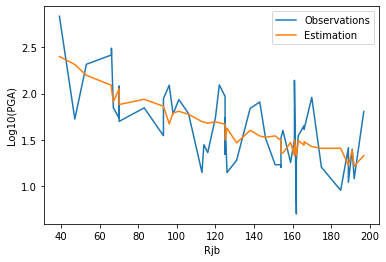

In [146]:
plt.plot(r_jb, d, label='Observations')
plt.plot(r_jb, d_estimation, label='Estimation')
plt.xlabel('Rjb')
plt.ylabel('Log10(PGA)')
plt.legend()
plt.show()

Text(0.5, 0, 'Rjb')

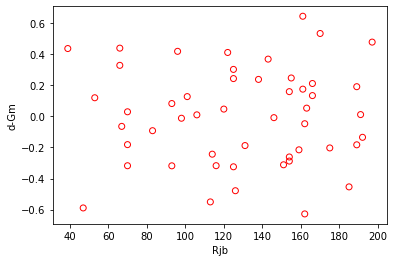

In [147]:
residual = d - d_estimation

plt.scatter(r_jb, residual, marker='o', facecolors='none', edgecolors='r')
plt.ylabel('d-Gm')
plt.xlabel('Rjb')

<h2><center>ب: تخمین میزان انحراف معیار داده‌ها</center></h2>

In [148]:
# remove Mean from data
G_rm = np.ones((pga.size, 2))
G_rm[:, 1] = r_jb
m_rm = np.linalg.inv(G_rm.T @ G_rm) @ G_rm.T @ pga
pga2 = G_rm @ m_rm
pga_rm = pga - pga2

In [149]:
sigma = np.sqrt(np.var(pga_rm))
print(f'{sigma=:.2f}')

sigma=89.34


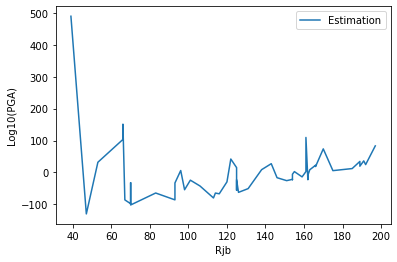

In [150]:
plt.plot(r_jb, pga_rm, label='Estimation')
plt.xlabel('Rjb')
plt.ylabel('Log10(PGA)')
plt.legend()
plt.show()

<h2><center>ج: بدست آوردن مقادیر میانگین و انحراف معیار مقادیر مدل به روش شبیه سازی مونته کارلو</center></h2>

In [151]:
# Model variance
cov_ml2 = (sigma**2) * np.linalg.inv(G.T@G)
cov_ml2 = np.diag(cov_ml2)
print('Model\tCovariance\n')
for ii, _ in enumerate(cov_ml2):
    print(f'm{ii+1}\t{_:.4f}')

Model	Covariance

m1	26120.9901
m2	5615.0144
m3	1053.2375
m4	1100.8318


<h6>Monte Carlo solution</h6>

In [152]:
Gw = G /  sigma
dimention = 4
number_of_simulation = 10000
mmc = np.zeros((number_of_simulation, dimention))
mmc_res = np.zeros((number_of_simulation, d_estimation.size))
for ii in range(number_of_simulation):
    # Generate a trial data set of perturbed, weighted data
    ytrial = d_estimation + sigma * np.random.randn(d_estimation.size)
    ywtrial = ytrial / sigma
    m_ = np.linalg.inv(Gw.T @ Gw) @ Gw.T @ ywtrial #np.linalg.lstsq(Gw, ywtrial)[0]
    ###
    mmc_res[ii, :] = ytrial - (Gw@m_)
    mmc[ii, :] = m_

m1	mean=5.6108	var=26640.4346
m2	mean=-1.7310	var=5703.0902
m3	mean=-0.0588	var=1065.5580
m4	mean=-0.3632	var=1118.0652


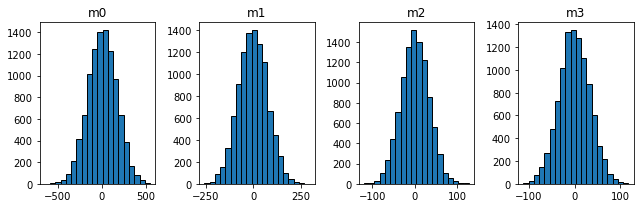

In [153]:
fig3, axs = plt.subplots(1, 4, figsize=(9, 3))
scale_labels = ['m', 'm/s', 'm/(s^2)']
for indx in range(4):
    m_ = mmc[:, indx]
    ax = axs[indx]
    ax.hist(m_, bins=20, edgecolor='black')
    ax.set_xlabel('')
    ax.set_title(f'm{indx}')
    mean = np.mean(m_)
    var = np.var(m_)
    print(f'm{indx+1}\t{mean=:.4f}\t{var=:.4f}')
    
plt.tight_layout()
plt.show()

<h2><center>د: ترسیم مقادیر باقیمانده بدست آمده از مدل بدست آمده در بخش ج  و اظهار نظر در خصوص شکل باقیمانده‌ها</center></h2>

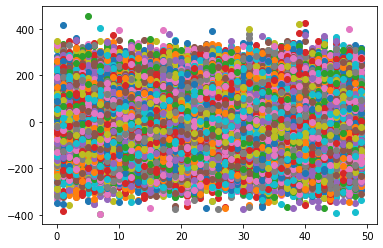

In [154]:
for ii in range(mmc_res.shape[0]):
#     plt.plot(mmc_res[ii, :])
    plt.plot(mmc_res[ii, :], 'o')

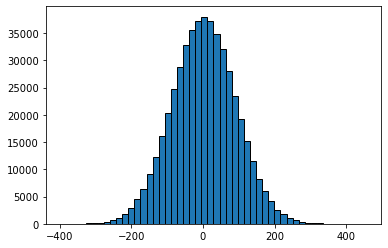

In [155]:
mmc_res = np.hstack(mmc_res)

a, bins, b =plt.hist(mmc_res, bins=50, edgecolor='black')

مدل بدست آمده از روش مونته‌کارلو

In [156]:
m_mc = np.mean(mmc, axis=0)
print(m_mc)
print(m)

[ 5.61075574 -1.73104061 -0.05878688 -0.36319059]
[ 4.6883825  -1.52149415  0.16918781  0.13195647]


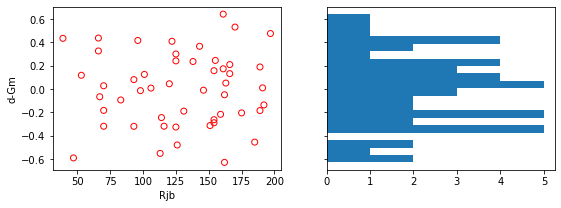

In [169]:
d_mc = G @ m
residual_mc = d - d_mc

fig2, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
ax0 = axs[0]
ax0.scatter(r_jb, residual, marker='o', facecolors='none', edgecolors='r')
ax0.set_ylabel('d-Gm')
ax0.set_xlabel('Rjb')

ax1 = axs[1]
ax1.hist(residual, bins=20, orientation='horizontal')
plt.show()

<center><h1>آیا باقی مانده‌ها دارای توزیع نرمال می‌باشند؟</h1></center>

بله مقادیری باقی‌مانده‌ها همانطور که در نمودار بالا مشخص است دارای توزیع نرمال می‌باشند